In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
!echo $CUDA_VISIBLE_DEVICES

1


In [2]:
import sys
sys.path.insert(0, "../")

import os
os.chdir("../")

In [3]:
from examples.qm9 import *
from examples.train import plot_sample_hist, eval_fn
import yaml
import matplotlib.pyplot as plt

/scratch/lim24/augmented-equivariant-flows/examples/train.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
2023-02-08 22:50:47.258668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-08 22:50:47.258767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-08 22:50:47.258778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

In [4]:
USE_64_BIT = False
if USE_64_BIT:
    from jax.config import config
    config.update("jax_enable_x64", True)

In [5]:
cfg = DictConfig(yaml.safe_load(open("examples/config/qm9.yaml")))
cfg

{'hydra': {'job': {'chdir': False}}, 'flow': {'dim': 3, 'nodes': 19, 'n_layers': 12, 'identity_init': True, 'type': 'proj_v2', 'kwargs': {'proj_v2': {'gram_schmidt': False}}, 'fast_compile': True, 'compile_n_unroll': 1, 'egnn': {'emile_net': False, 'mlp_units': [32, 32], 'n_layers': 3, 'normalize_by_norms': True, 'variance_scaling_init': 0.001, 'tanh': False, 'agg': 'mean', 'phi_x_max': 1.0, 'normalization_constant': 1.0, 'h': {'linear_softmax': True, 'share_h': True}}, 'transformer': {'mlp_units': [32, 32], 'num_heads': 6, 'key_size': 16, 'w_init_scale': 0.1, 'n_layers': 3}}, 'training': {'lr': '8e-5', 'optimizer_name': 'adamw', 'n_epoch': 200, 'batch_size': 32, 'plot_batch_size': 32, 'max_global_norm': 20000, 'seed': 0, 'reload_aug_per_epoch': True, 'train_set_size': None, 'test_set_size': None, 'n_plots': 10, 'n_checkpoints': 8, 'n_eval': 12, 'K_marginal_log_lik': 20, 'save': True, 'save_dir': 'qm9pos_results'}, 'logger': {'wandb': {'name': 'qm9pos_${flow.type}_tanh${flow.egnn.tanh}

In [6]:
cfg.training.lr = 4e-4
cfg.flow.type = "vector_scale_shift"
cfg.flow.n_layers=4
cfg.flow.egnn.mlp_units = (16,)
cfg.flow.transformer.mlp_units = (16,)
cfg.flow.egnn.n_layers = 3
cfg.training.batch_size = 100
cfg.training.n_epoch = 80
cfg.training.save = False
cfg.training.plot_batch_size = 128
cfg.logger = DictConfig({"list_logger": None})
cfg.training.n_plots = 4
cfg.training.n_eval = 4
cfg.training.K_marginal_log_lik = 5

training data shape of (13800, 19, 6)


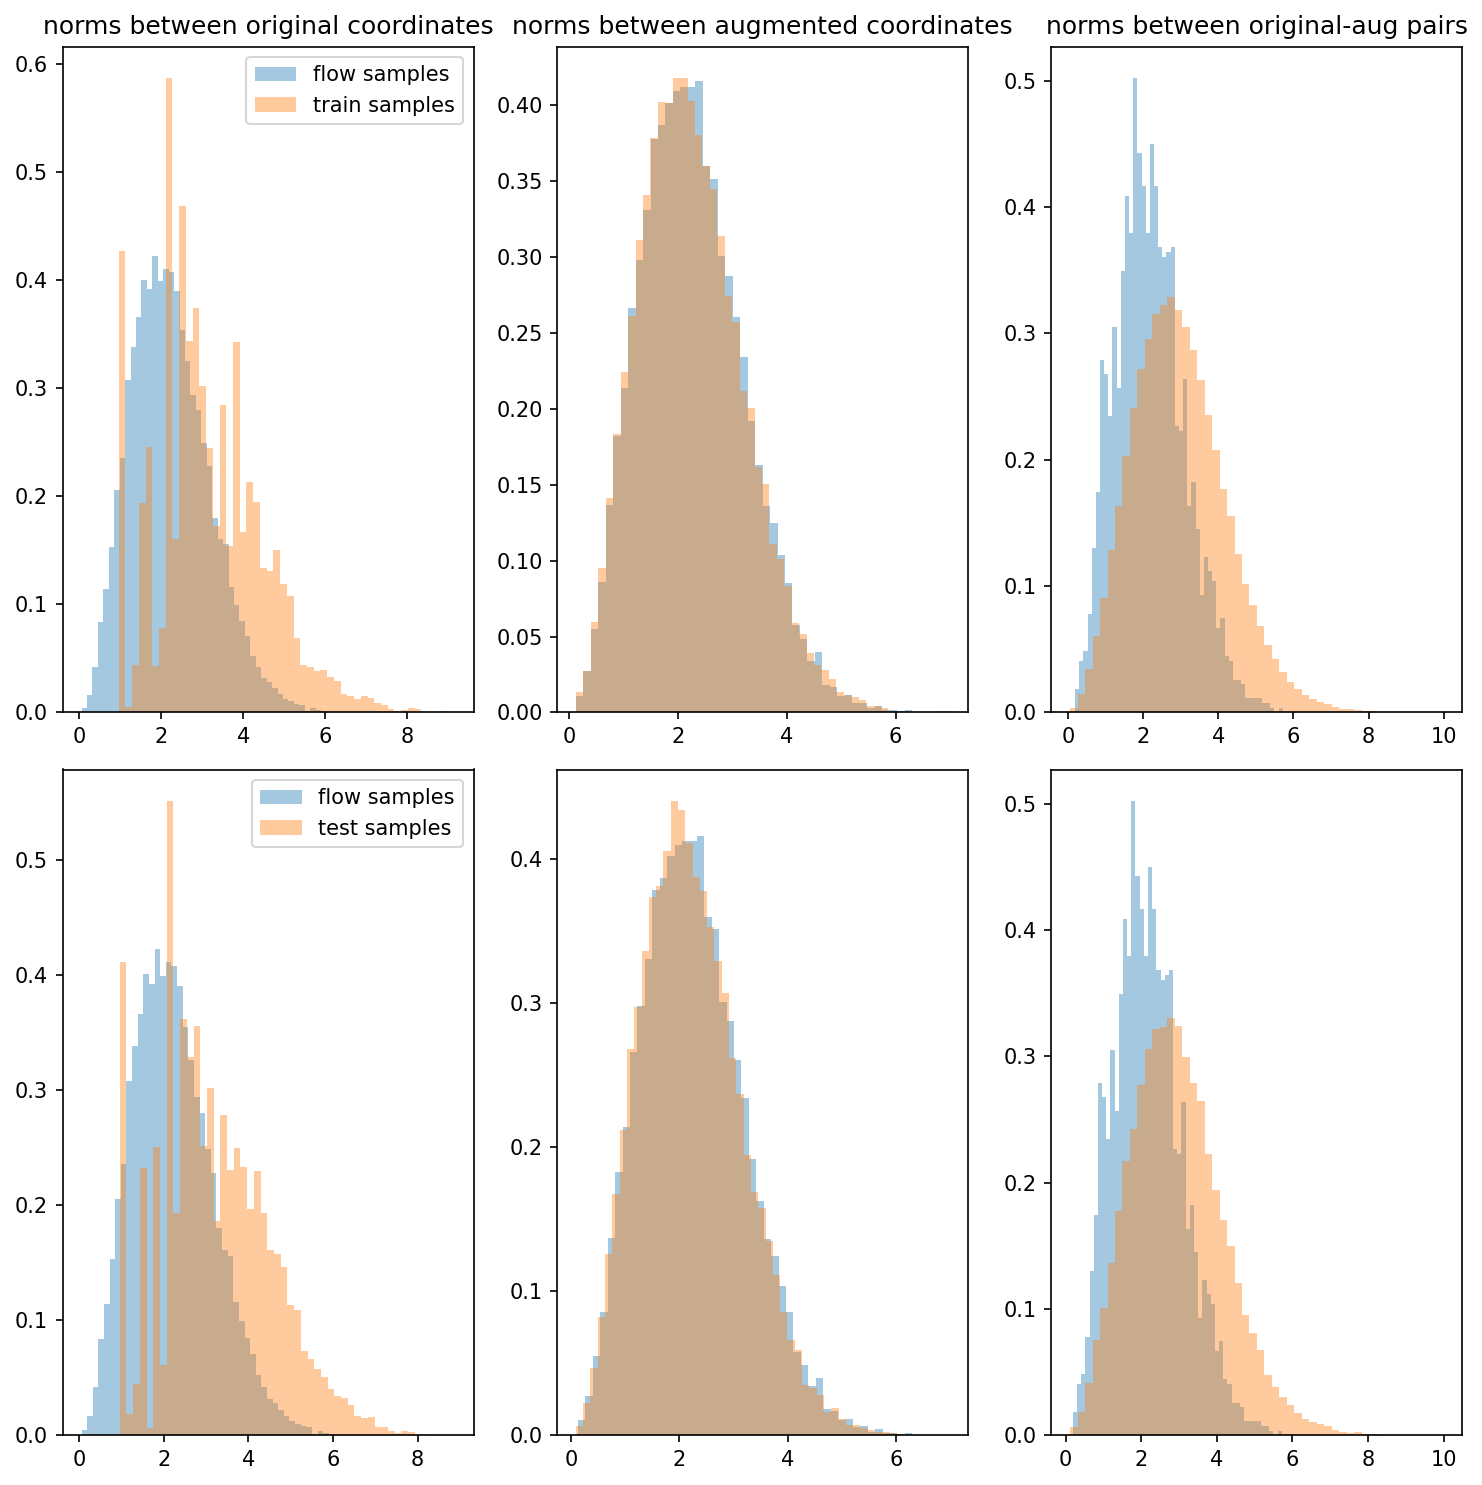

  0%|                                                    | 0/80 [00:00<?, ?it/s]

non numeric history values being saved


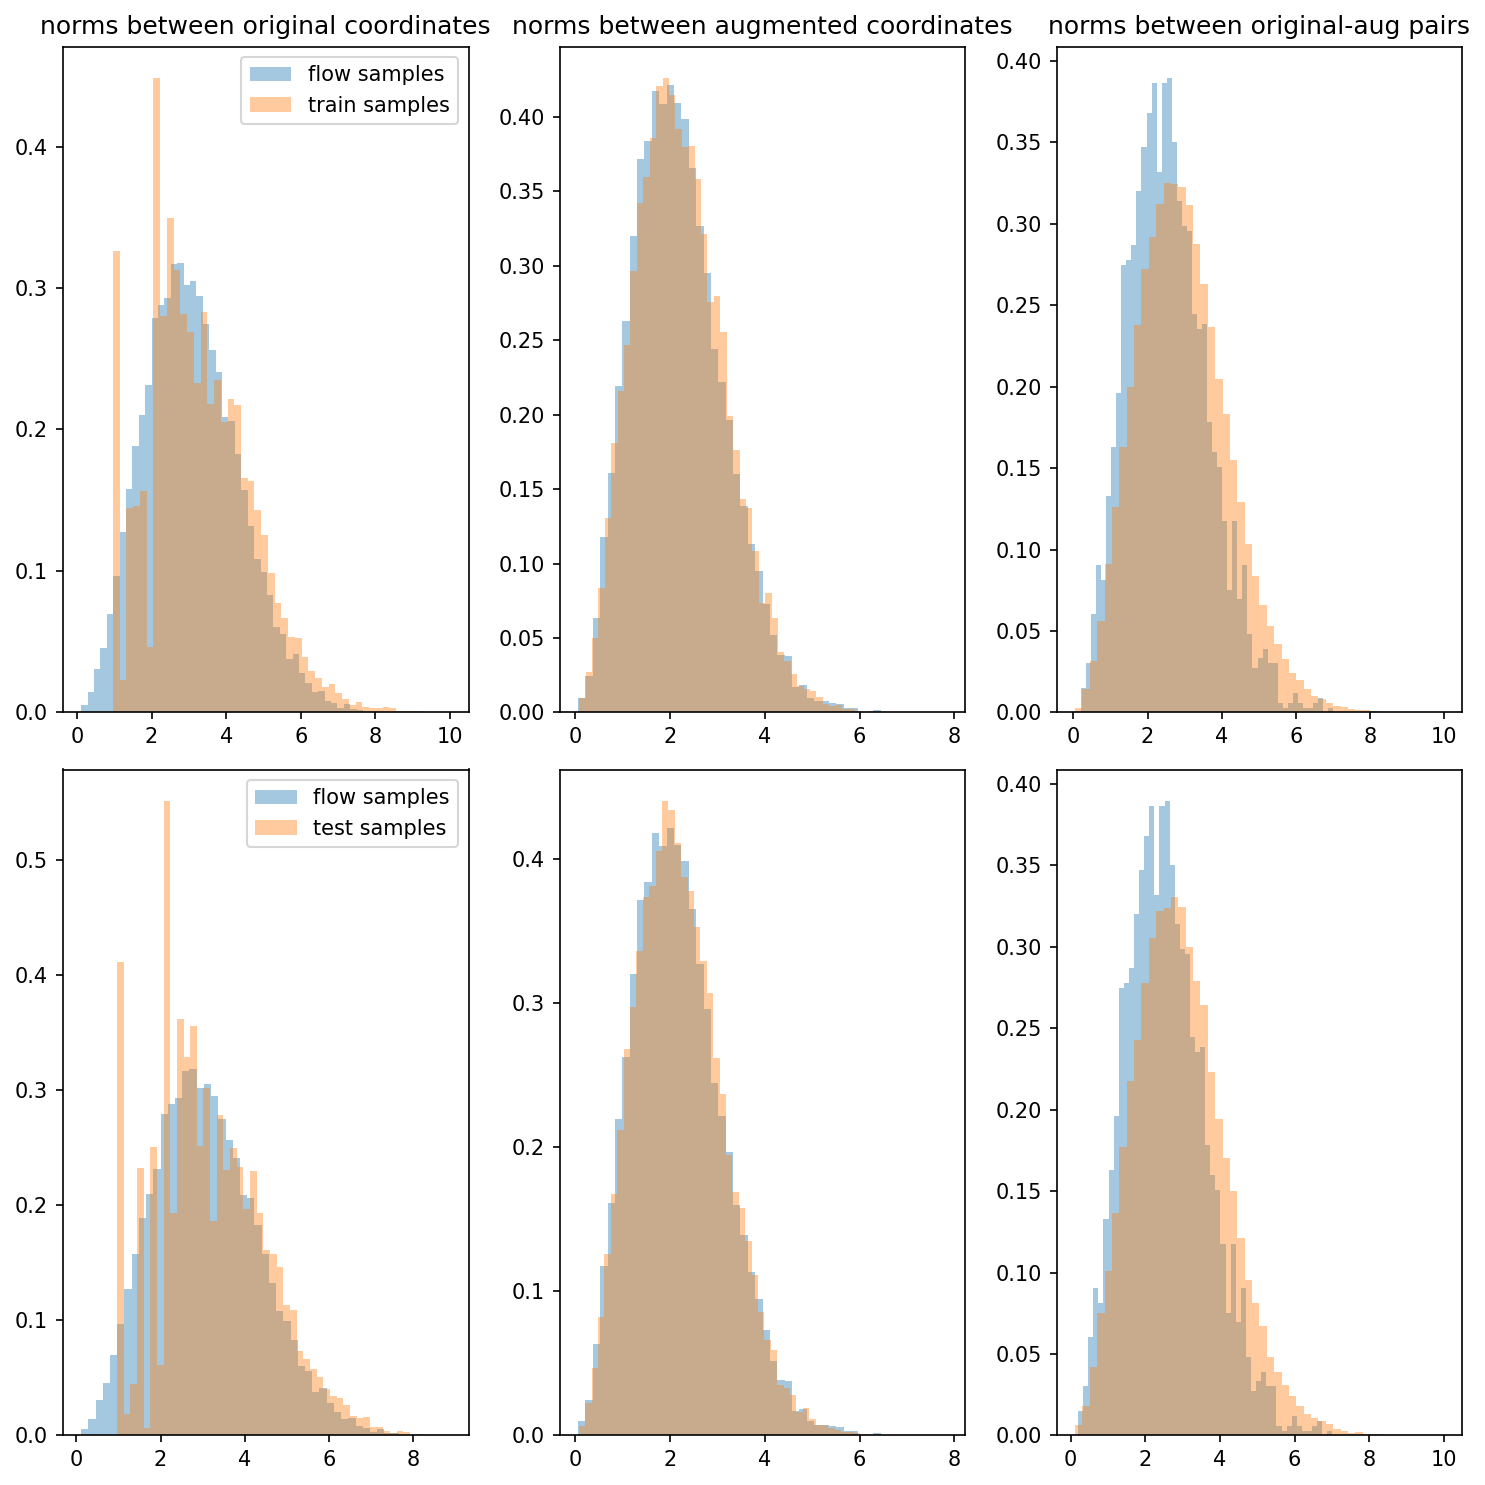

  1%|▌                                         | 1/80 [01:00<1:19:50, 60.63s/it]

{'eval_log_lik': Array(-172.47299, dtype=float32), 'eval_marginal_log_lik': Array(-91.23027, dtype=float32)}


 32%|█████████████▉                             | 26/80 [06:35<12:05, 13.43s/it]

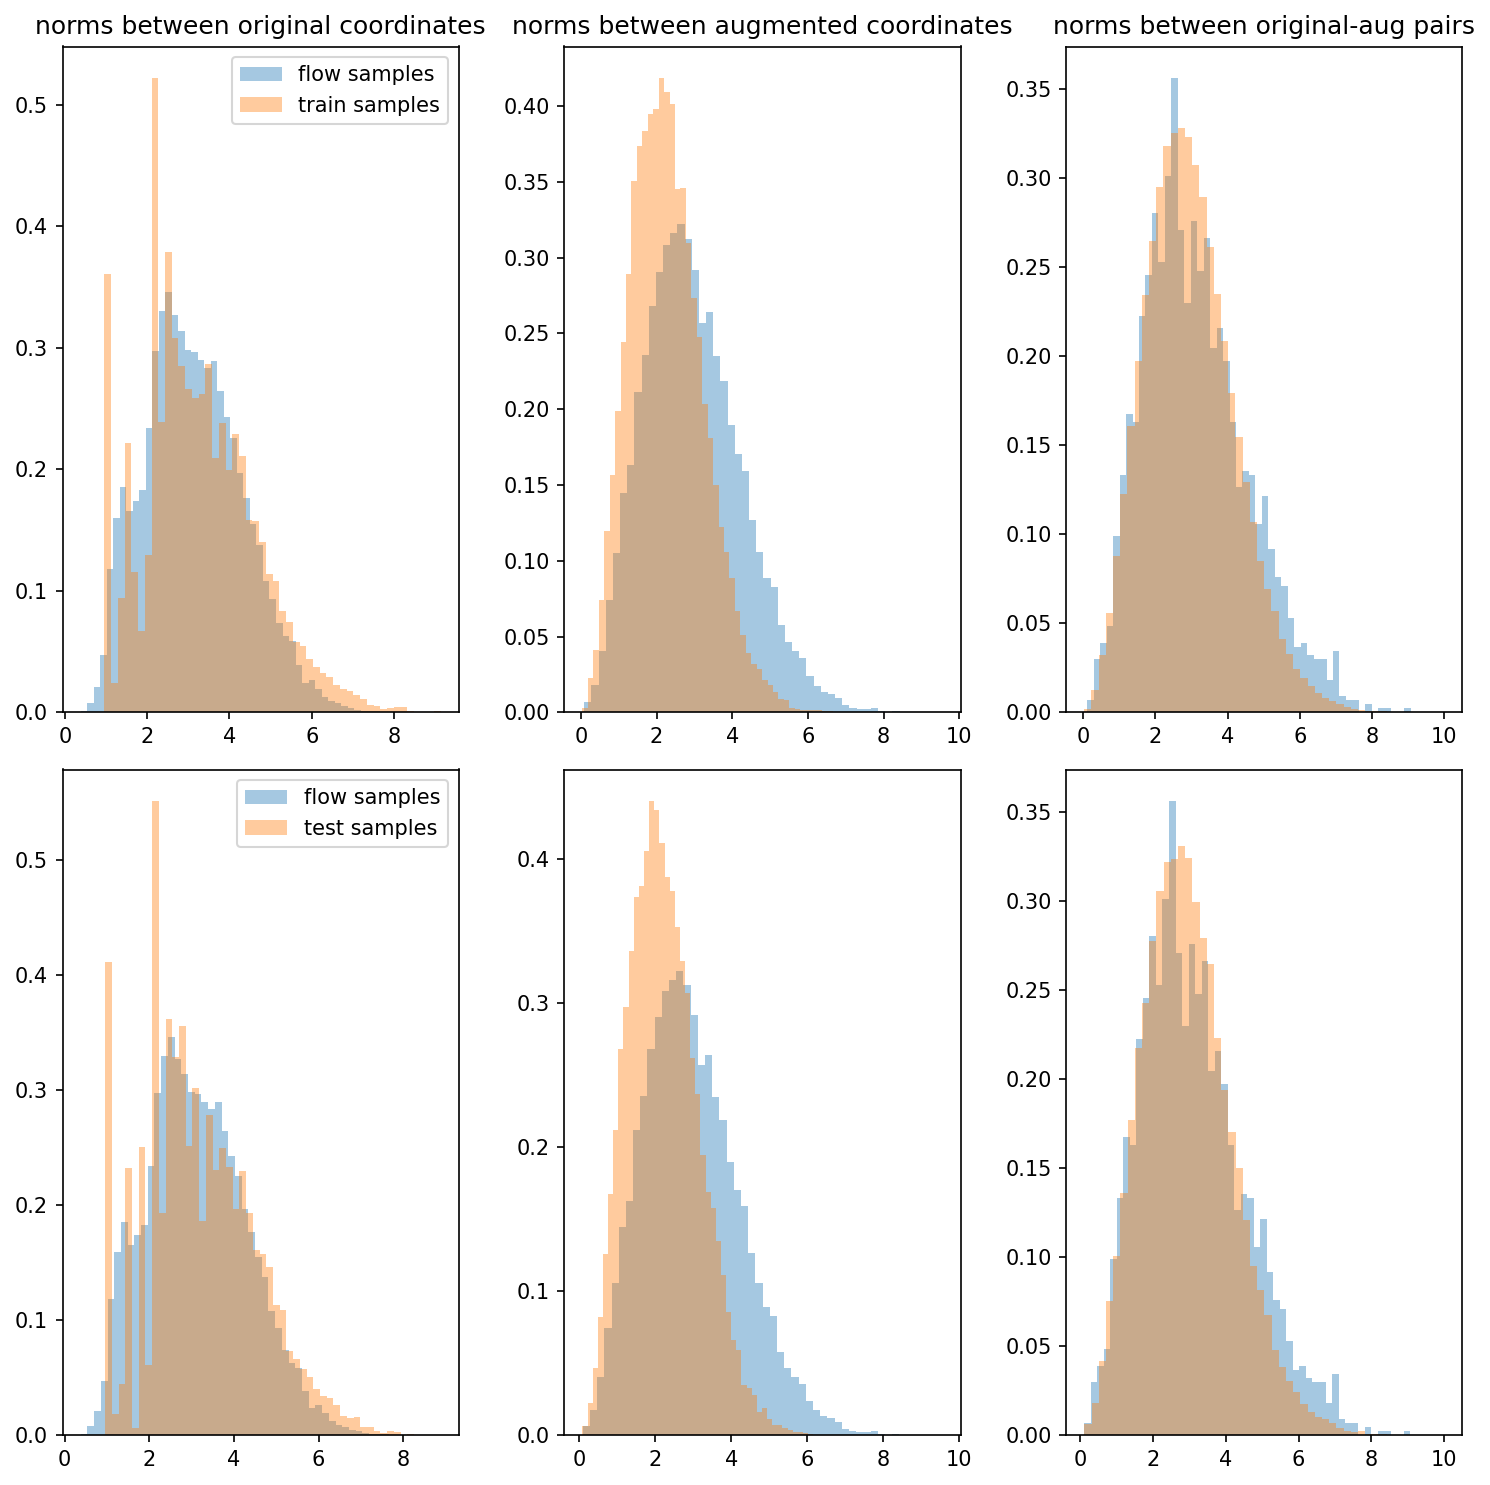

 34%|██████████████▌                            | 27/80 [07:12<17:59, 20.36s/it]

{'eval_log_lik': Array(-149.71341, dtype=float32), 'eval_marginal_log_lik': Array(-68.29432, dtype=float32)}


 65%|███████████████████████████▉               | 52/80 [12:48<06:16, 13.44s/it]

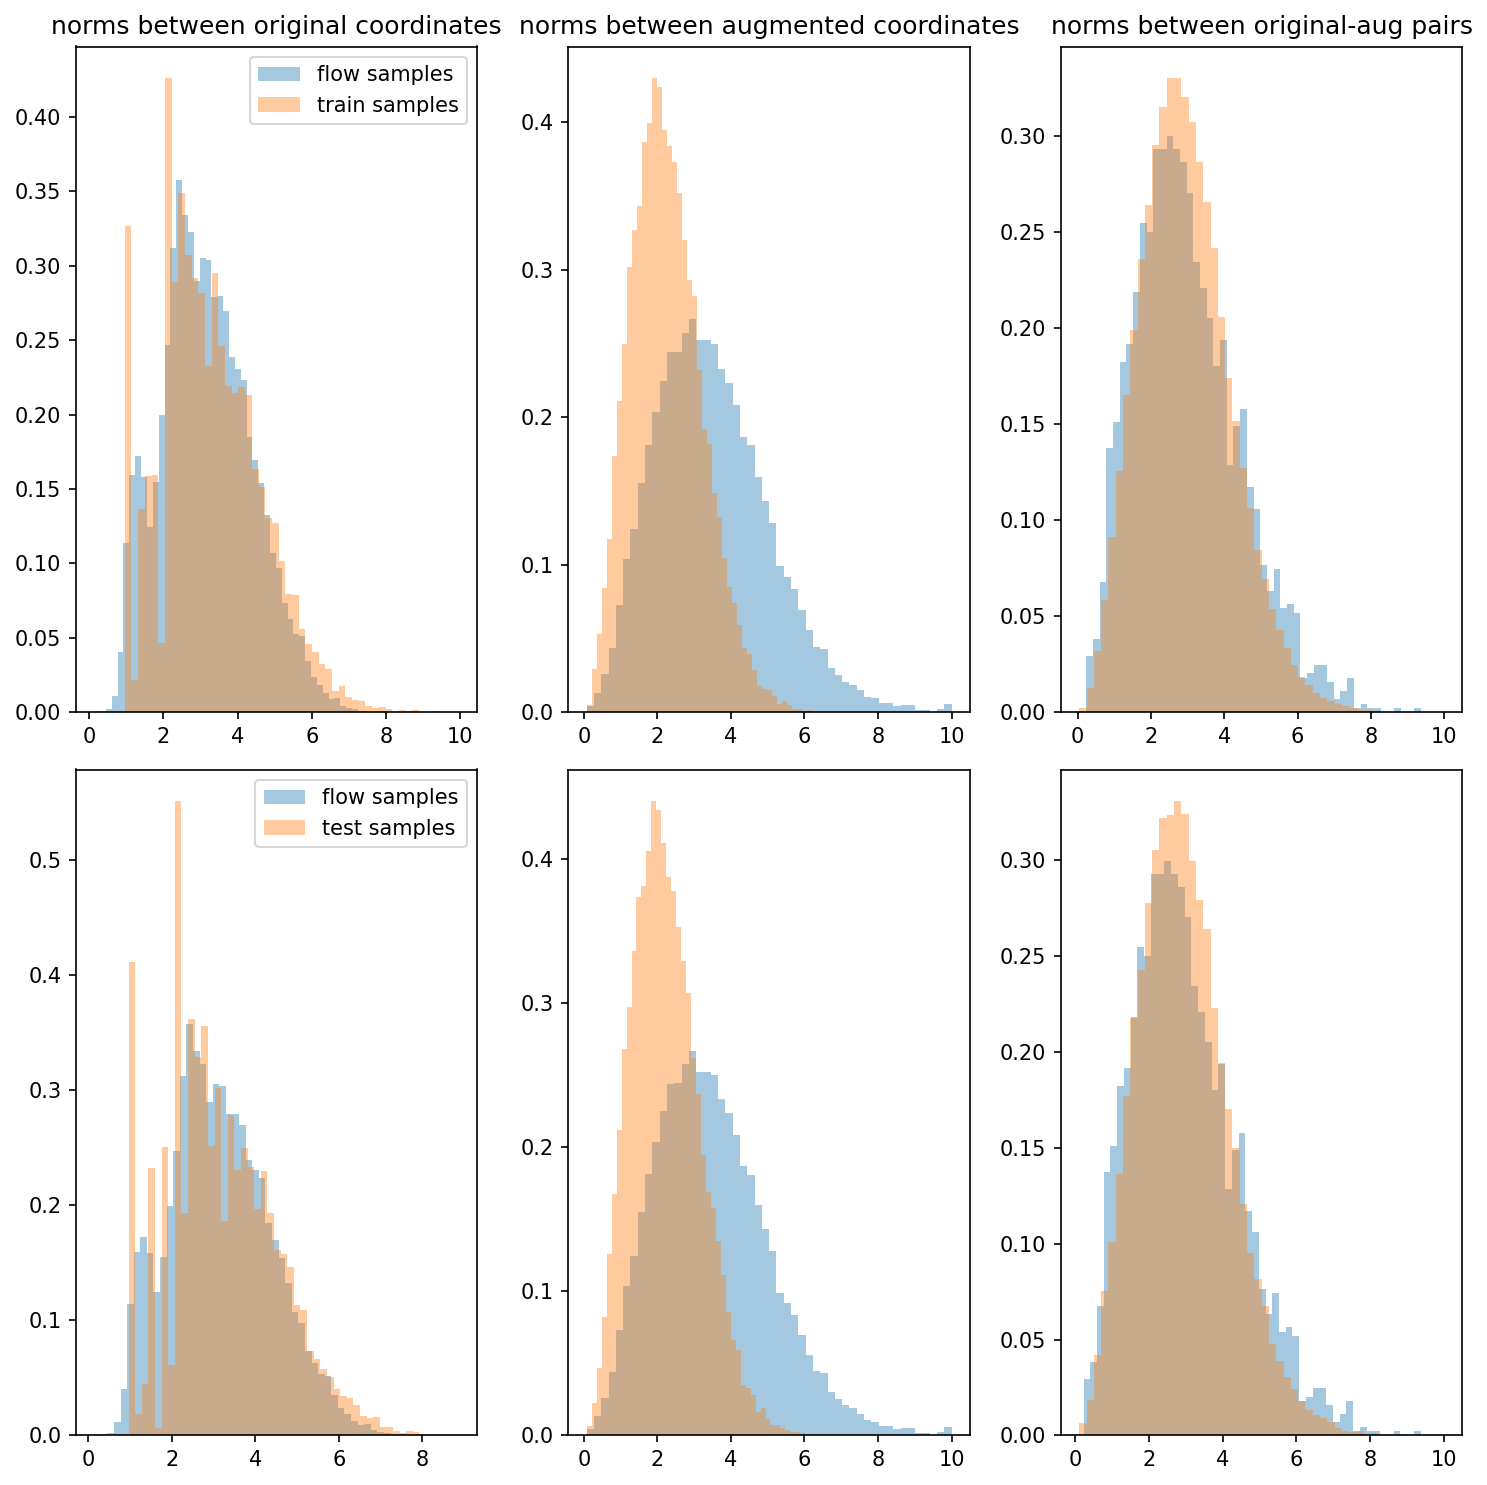

 66%|████████████████████████████▍              | 53/80 [13:24<09:11, 20.44s/it]

{'eval_log_lik': Array(-142.09767, dtype=float32), 'eval_marginal_log_lik': Array(-60.558723, dtype=float32)}


 99%|██████████████████████████████████████████▍| 79/80 [19:13<00:13, 13.44s/it]

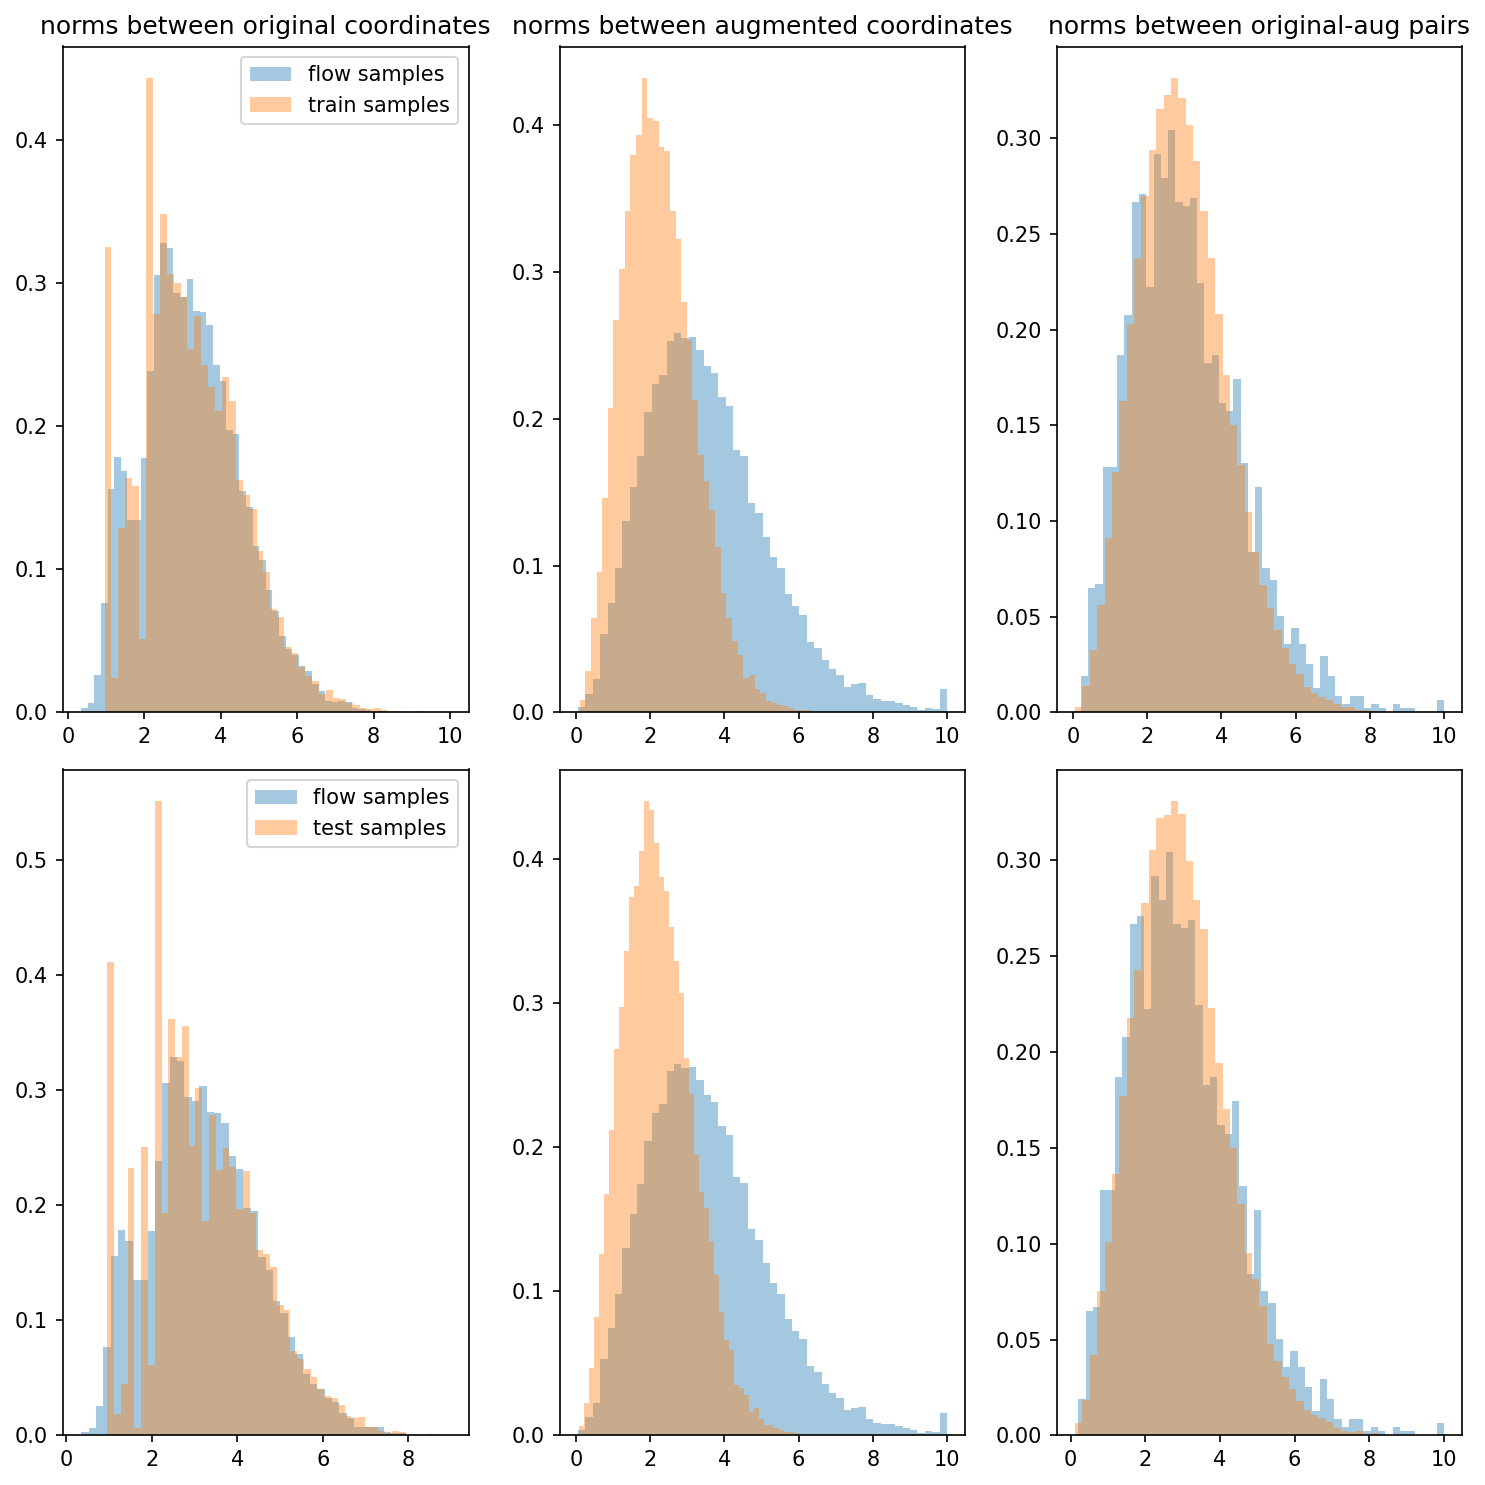

100%|███████████████████████████████████████████| 80/80 [19:50<00:00, 14.88s/it]


{'eval_log_lik': Array(-138.71193, dtype=float32), 'eval_marginal_log_lik': Array(-57.26041, dtype=float32)}


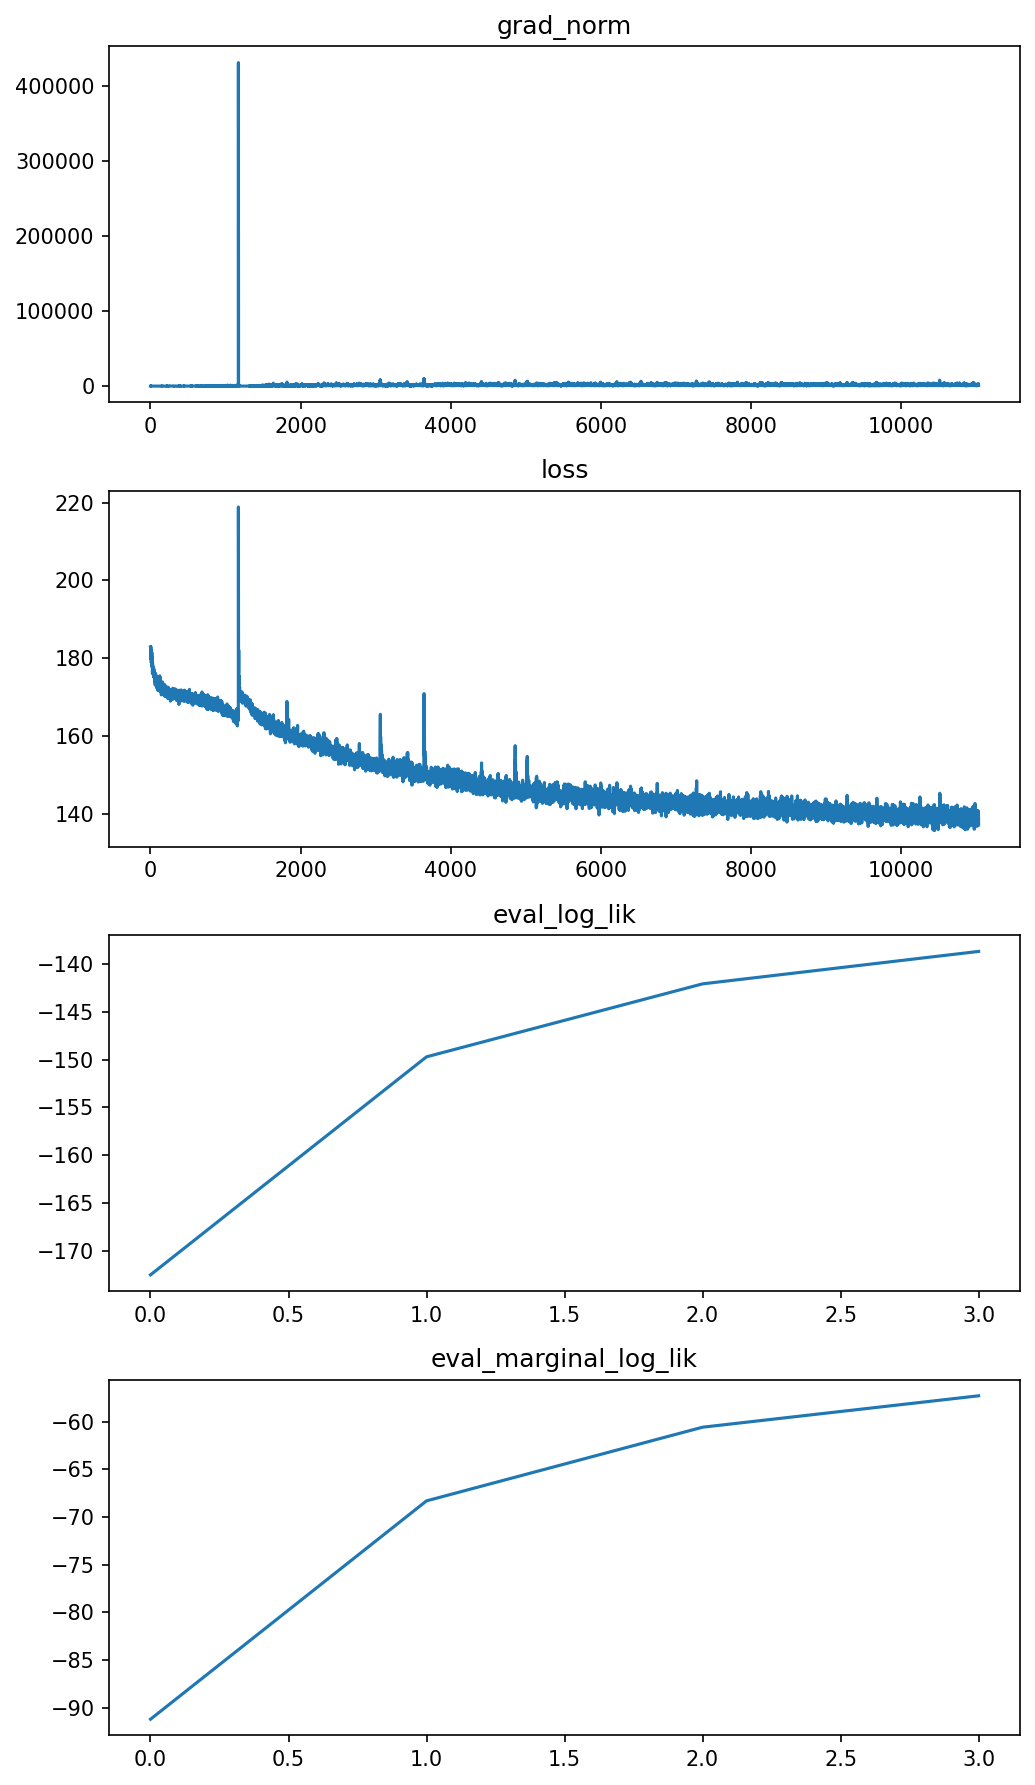

In [7]:
experiment_config = create_train_config(cfg, dim=3, n_nodes=19,
                                        load_dataset=load_dataset)

logger, params, log_prob_fn, sample_and_log_prob_fn = train(experiment_config)



In [8]:
train_data, test_data = load_dataset(batch_size=cfg.training.batch_size, train_set_size=1000, test_set_size=1000)
x = sample_and_log_prob_fn.apply(params, jax.random.PRNGKey(1), (512,))[0]

TypeError: load_dataset() got an unexpected keyword argument 'train_set_size'

In [ ]:
fig, axs = plt.subplots()
plot_sample_hist(test_data, axs, original_coords=True, label='test samples')
plot_sample_hist(train_data, axs, original_coords=True, label='train samples')
plot_sample_hist(x, axs, original_coords=True, label='flow samples')
axs.set_title("sample histogram")
axs.legend()

In [ ]:
eval_fn(params=params, x=test_data, flow_log_prob_fn=log_prob_fn,
                                flow_sample_and_log_prob_fn=sample_and_log_prob_fn,
                                target_log_prob=dw4.log_prob_fn,
                                key=jax.random.PRNGKey(1), batch_size=cfg.training.batch_size,
                                K=50)